# Import dependencies

In [1]:
# Import management
from importlib import reload

# Data Manipulations and Preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# Data Visualization
import matplotlib.pyplot as plt

# Tuning & Splitting Libraries
from sklearn.model_selection import train_test_split

# Services
import services.ModelStageService as sds

# utils
import datetime
import utils.EDAUtils as edaUtils
import utils.ModelTrainingAndEvaluationUtils as mteUtils
import utils.DataTransformationUtils as dtUtils
import utils.PlottingUtils as pltUtils

# Reload all custom dependencies
reload(sds)
reload(edaUtils)
reload(mteUtils)
reload(dtUtils)
reload(pltUtils)

# Create model stage instance
stage_data_io_service = sds.ModelStageService(
    previous_stage_name=sds.PREPROCESSING_STAGE,
    current_stage_name=sds.FEATURE_ENGINEERING_STAGE
)

# Load data

In [2]:
# Reading text from txt file
df = stage_data_io_service.run_or_load_stage_data(reload_stage=False)

INFO:papermill:Input Notebook:  ../../model/stages/2_data_preprocessing.ipynb


INFO:papermill:Output Notebook: ../../model/stages/2_data_preprocessing.ipynb


Reload stage False path ../../data/stages/PREPROCESSING_stage_data.pkl exists False
Running 2_data_preprocessing.ipynb...


Executing:   0%|          | 0/15 [00:00<?, ?cell/s]

INFO:papermill:Executing notebook with kernel: python3


2_data_preprocessing.ipynb completed.
Loading PREPROCESSING from snapshot.
Loading PREPROCESSING from snapshot.


# Feature Engineering and Data Processing for Model Building

## Adding Synthetic Replenishment Data for Accurate Calculation of Credit Debt Repayment Stability (CDRS) Ratio

Before calculating the Credit Debt Repayment Stability (CDRS) ratio, it is crucial to account for all transactions affecting the available balance, especially replenishments. However, the dataset lacks direct information on replenishment transactions, except for specific cases like reversal transactions. This absence introduces potential inaccuracies when calculating repayment stability.

To resolve this issue without altering the data schema by adding new markers, we will synthetically generate missing replenishment transactions. The approach works as follows:

1. **Data Grouping and Sorting**: We group the transactions by account number and arrange them in chronological order to establish a clear transaction flow.
   
2. **Pairwise Transaction Comparison**: After sorting, we compare each transaction with the preceding one. If the available balance of the current transaction exceeds that of the previous one and the previous transaction is not classified as a reversal or address verification, we infer that a replenishment transaction was missing between the two.

3. **Synthetic Replenishment Insertion**: For each identified gap, a synthetic replenishment transaction is inserted with a calculated amount and timestamp. This ensures that all changes in the available balance are accurately reflected in the dataset, allowing for a more precise calculation of the CDRS ratio.

By synthesizing replenishment data in this way, we can achieve a more accurate and realistic assessment of credit debt 
repayment behavior without distorting the original dataset's structure.


In [3]:
def add_skipped_replenishment_transactions(df):
    """
    Adds synthetic replenishment transactions to a DataFrame of financial transactions.

    The method processes transaction data for each account, ensuring replenishment transactions 
    are inserted when missing. It works by grouping transactions by account number, 
    sorting them chronologically, and checking if a replenishment transaction is needed 
    between consecutive transactions. If the available balance of a later transaction 
    is greater than the previous one (and the previous transaction is not a reversal or address verification), 
    a replenishment transaction is added synthetically.

    Parameters:
    df (pd.DataFrame): DataFrame containing transaction data.

    Returns:
    pd.DataFrame: The original DataFrame with added synthetic replenishment transactions. 
    The output will be sorted by 'accountNumber' and 'transactionDateTime'.
    """

    # Sort data by account number and transaction datetime
    df = df.sort_values(['accountNumber', 'transactionDateTime']).reset_index(drop=True)

    # List to store new replenishment transactions
    replenishments = []

    # Group transactions by account number
    grouped = df.groupby('accountNumber')

    # Iterate over each account group
    for account, group in grouped:
        # Create a replenishment before the first transaction
        first_transaction = group.iloc[0]
        replenish_row = first_transaction.copy()
        replenish_row['transactionDateTime'] = first_transaction['transactionDateTime'] - datetime.timedelta(days=1)
        replenish_row['transactionAmount'] = first_transaction['creditLimit']
        replenish_row['enteredCVV'] = first_transaction['cardCVV']
        replenish_row['transactionType'] = 'REPLENISHMENT'
        replenish_row['isFraud'] = False
        replenishments.append(replenish_row)

        # Process the rest of the transactions
        for i in range(1, len(group)):
            current_transaction = group.iloc[i]
            previous_transaction = group.iloc[i - 1]

            # Check if a replenishment is needed between transactions
            if (current_transaction['availableMoney'] >= previous_transaction['availableMoney'] and
                    previous_transaction['transactionAmount'] != 0 and
                    previous_transaction['transactionType'] not in ['REVERSAL', 'ADDRESS_VERIFICATION']):
                # Calculate the replenishment datetime
                difference = current_transaction['transactionDateTime'] - previous_transaction['transactionDateTime']
                replenishment_transaction_date_time = (
                    current_transaction['transactionDateTime'] if difference <= datetime.timedelta(0)
                    else current_transaction['transactionDateTime'] - difference / 2
                )

                # Create replenishment transaction
                replenish_row = previous_transaction.copy()
                replenish_row['transactionDateTime'] = replenishment_transaction_date_time
                replenish_row['availableMoney'] = previous_transaction['availableMoney'] - previous_transaction[
                    'transactionAmount']
                replenish_row['creditDebt'] = previous_transaction['creditDebt'] + previous_transaction[
                    'transactionAmount']
                replenish_row['transactionAmount'] = current_transaction['availableMoney'] - replenish_row[
                    'availableMoney']
                replenish_row['enteredCVV'] = previous_transaction['cardCVV']
                replenish_row['transactionType'] = 'REPLENISHMENT'
                replenish_row['isFraud'] = False

                # Append replenishment to the list
                replenishments.append(replenish_row)

    # Convert replenishments to DataFrame and merge with the original DataFrame
    replenishment_df = pd.DataFrame(replenishments)
    result_df = pd.concat([df, replenishment_df]).sort_values(['accountNumber', 'transactionDateTime']).reset_index(
        drop=True)

    return result_df

df = stage_data_io_service.run_or_load_snapshot_data('add_skipped_replenishment_transactions',
                                                     add_skipped_replenishment_transactions,
                                                     df,
                                                     recreate_snapshot=False
                                                     )


Created snapshot folder: ../../data/snapshots/feature_engineering/
Processing add_skipped_replenishment_transactions...


### Check dimension after adding new rows

In [4]:
edaUtils.data_summary(df)

Dimensions: 855029 rows, 21 columns
Total NA's: 0
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     5000            0         
creditLimit                            float64    10              0         
availableMoney                         float64    567314          0         
transactionDateTime                    datetime64[ns] 844349          0         
transactionAmount                      float64    106311          0         
acqCountry                             object     4               0         
merchantCountryCode                    object     4               0         
posEntryMode                           object     5               0         
posConditionCode                       object     3               0         
merchantCategoryCode                   object     19              0         
currentExpDate                         datetime64[ns] 165 

## Credit debt repayment stability ratio (CDRS Ratio)

### Overview
The primary goal of this analysis is to explore the relationship between a customer's spending and repayment patterns and the likelihood of fraudulent activity (`isFraud`). Specifically, we calculate a **stability coefficient** that reflects how consistently a customer closes their credit debt over time, then analyze how this coefficient correlates with fraud probability.

### Key Variables

1. **Spending Percentage**: The percentage of the credit limit that was spent between full debt repayments.
 $$ \text{Spent Percentage} = \left( \frac{\text{Total Amount Spent}}{\text{Credit Limit}} \right) \times 100 $$

2. **Days Between Resets**: The number of days between two consecutive events where the available balance equals the credit limit (i.e., the debt is fully repaid).

### Stability ratio

To measure customer stability, we consider two factors:
- The **average spending percentage** between resets.
- The **average number of days** between resets.

These two values are normalized using Min-Max normalization to bring them into the range of [0, 1]. The final stability coefficient is computed as:

$$ \text{CDRS Ratio} = 1 - (\text{Normalized Spending Percentage Between Resets} \times \text{Normalized Days Between Resets}) $$

This coefficient ranges from 0 to 1, where:
- A value closer to **1** indicates a more stable customer (less spending, more frequent repayments).
- A value closer to **0** indicates less stable repayment behavior.

### Hypothesis
We hypothesize that a higher stability coefficient (more stable customers) correlates with a lower probability of fraudulent activity. Conversely, lower stability may indicate higher fraud risk.

### Fraud Analysis
Once the CDRS Ratio is calculated for each account, we group the accounts into ranges (bins) of stability coefficients and calculate the percentage of fraudulent transactions (`isFraud = True`) in each range. The results are visualized to test the hypothesis.

### Conclusion
This analysis can help identify patterns between customer behavior and fraud risk, providing valuable insights for improving fraud detection models.

### Nice to fix and improve
- Investigate anomaly in cdrs-ratio range from 0.222-0.333 -- 0.333-0.444
- Improve scaling function (when size of input is 1)
- Investigate and fix when normalized `avg_norm_days_between_resets` is NaN (reason might be in scaling function)


Processing calculate_cdrs_ratio...


C:\ILLIA\CODDING\DATA_SCIENCE\FTF-detector\utils\DataTransformationUtils.py:18: RuntimeWarning: invalid value encountered in divide
  return (np.array(values) - min(values)) / (max(values) - min(values))


C:\Users\gorba\AppData\Local\Temp\ipykernel_18580\3747772818.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_stats = df_merged.groupby('cdrs_range').agg(


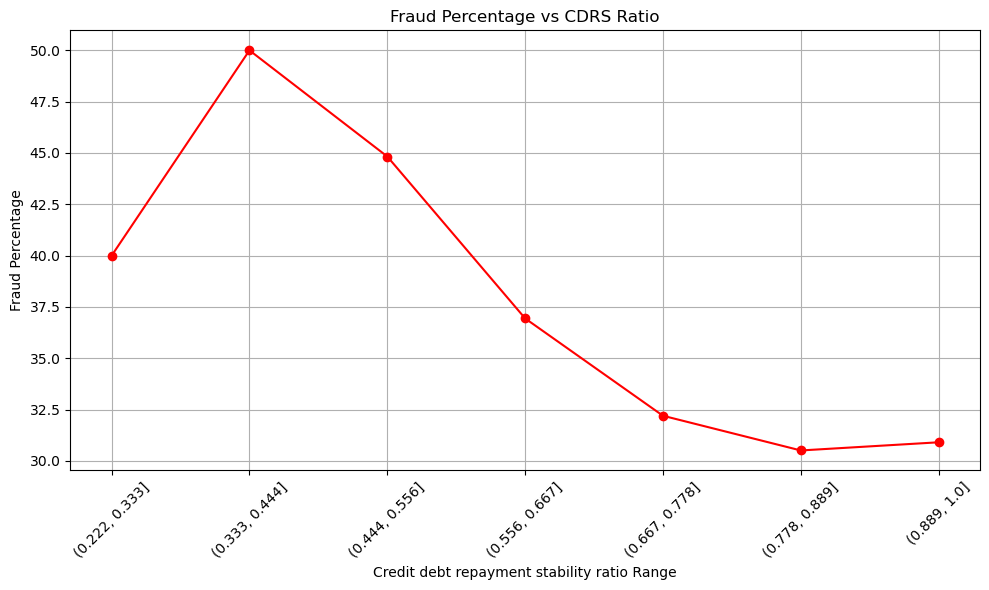

In [5]:

# Function to visualize fraud percentage based on stability coefficient
def visualize_fraud_vs_cdrs_ratio(fraud_stats):
    """
    Visualizes the fraud percentage based on cdrs ratio ranges.

    Parameters:
    fraud_stats: DataFrame containing fraud statistics grouped by cdrs ratio ranges.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(fraud_stats.index.astype(str), fraud_stats['fraud_percentage'], marker='o', linestyle='-', color='r')
    plt.title('Fraud Percentage vs CDRS Ratio')
    plt.xlabel('Credit debt repayment stability ratio Range')
    plt.ylabel('Fraud Percentage')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def calculate_account_stability_stats(account, transactions, reset_indices, stability_data):
    days_between_resets = []
    spent_percentages = []
    # Calculate the amount spent and days between credit limit resets
    for i in range(1, len(reset_indices)):
        start_idx = (reset_indices[i - 1]) + 1  # not include transaction of replenishment
        end_idx = (reset_indices[i]) - 1  # not include transaction of replenishment

        # Exclude replenishment transactions from the spending calculation
        transaction_slice = transactions.loc[start_idx:end_idx]
        non_replenishment_transactions = transaction_slice[
            (transaction_slice['transactionType'] != 'REPLENISHMENT') &
            (transaction_slice['transactionType'] != 'ADDRESS_VERIFICATION') &
            (transaction_slice['transactionType'] != 'REVERSAL')
            ]

        # Calculate the total amount spent between resets
        total_spent = non_replenishment_transactions['transactionAmount'].sum()
        credit_limit = transactions.loc[start_idx, 'creditLimit']

        spent_percentage = abs((total_spent / credit_limit) * 100)
        spent_percentages.append(spent_percentage)

        # Calculate the number of days between the two resets
        start_date = transactions.loc[start_idx, 'transactionDateTime']
        end_date = transactions.loc[end_idx, 'transactionDateTime']
        days_between = (end_date - start_date).days
        days_between_resets.append(days_between)

    # Normalize spent percentages and days between resets
    norm_spent_percentages = dtUtils.min_max_normalize(spent_percentages)
    norm_days_between_resets = dtUtils.min_max_normalize(days_between_resets)
    # Calculate the average normalized values
    avg_norm_spent_percentage = np.mean(norm_spent_percentages)
    avg_norm_days_between_resets = np.mean(norm_days_between_resets)
    # Stability ratio: higher values mean the customer is more stable
    cdrs_ratio = 1 - (avg_norm_spent_percentage * avg_norm_days_between_resets)
    stability_data.append({
        'accountNumber': account,
        'creditLimit': transactions.iloc[0].creditLimit,
        'avg_norm_spent_percentage': avg_norm_spent_percentage,
        'avg_norm_days_between_resets': avg_norm_days_between_resets,
        'cdrs_ratio': cdrs_ratio
    })

def calculate_fraud_stats(df, stability_stats):
    # Merge with the original DataFrame on accountNumber
    df_merged = df[['accountNumber', 'isFraud']].drop_duplicates().merge(stability_stats, on='accountNumber',
                                                                         how='left')
    # Create bins for stability coefficient ranges
    df_merged['cdrs_range'] = pd.cut(df_merged['cdrs_ratio'], bins=np.linspace(0, 1, 10))
    # Calculate fraud percentage in each stability coefficient range
    fraud_stats = df_merged.groupby('cdrs_range').agg(
        fraud_count=('isFraud', lambda x: (x == True).sum()),
        total_count=('isFraud', 'count')
    )
    fraud_stats['fraud_percentage'] = (fraud_stats['fraud_count'] / fraud_stats['total_count']) * 100
    return fraud_stats

def calculate_cdrs_ratio(df, credit_cover_threshold):
    df = df.sort_values(['accountNumber', 'transactionDateTime'])

    stability_data = []

    # Loop through each account and calculate stability coefficient
    for account, transactions in df.groupby('accountNumber'):
        transactions = transactions.reset_index(drop=True)

        # Find indices where credit limit is reset (repaid based on the X percent threshold)
        reset_indices = transactions[
            (transactions['transactionType'] == 'REPLENISHMENT') &
            ((transactions['transactionAmount'] + transactions['availableMoney']) >= transactions[
                'creditLimit'] * credit_cover_threshold)
            ].index.tolist()

        if len(reset_indices) < 2:
            continue  # Skip accounts with insufficient data for calculation. Ratio for these account will be predicted by other model

        calculate_account_stability_stats(account, transactions, reset_indices, stability_data)

    # Create DataFrame with stability coefficients for each account
    stability_stats = pd.DataFrame(stability_data)

    fraud_stats = calculate_fraud_stats(df, stability_stats)

    # Add stability coefficient to the original DataFrame
    df = df.merge(stability_stats, on='accountNumber', how='left')

    return df, fraud_stats, stability_stats

df_with_stability, fraud_stats, tuned_stability_stats = stage_data_io_service.run_or_load_snapshot_data(
    'calculate_cdrs_ratio',
    calculate_cdrs_ratio,
    df,
    1,
    recreate_snapshot=False
)
visualize_fraud_vs_cdrs_ratio(fraud_stats)

In [6]:
edaUtils.data_summary(df_with_stability)

Dimensions: 855029 rows, 25 columns
Total NA's: 1157573
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     5000            0         
creditLimit_x                          float64    10              0         
availableMoney                         float64    567314          0         
transactionDateTime                    datetime64[ns] 844349          0         
transactionAmount                      float64    106311          0         
acqCountry                             object     4               0         
merchantCountryCode                    object     4               0         
posEntryMode                           object     5               0         
posConditionCode                       object     3               0         
merchantCategoryCode                   object     19              0         
currentExpDate                         datetime64[ns

## Predicting CDRS ratio for account with insufficient replenishments according to threshold
After calculating CDRS, we visualized the obtained values on the graph. It allowed
to reveal an important regularity: the higher the stability coefficient, the lower it is
the level of crime among customers, which confirms the correctness of our hypothesis.
That is, increasing stability in debt repayment is associated with greater reliability
client, which reduces the likelihood of his involvement in fraudulent activities.

Visualization showed that higher values of the stability coefficient (CDRS) correlate with lower values
fraud rates among users, confirming its usefulness coefficient for building the main model. So it can be concluded that 
this ratio can be an important tool to improve accuracy predicting fraud based on debt repayment stability.

However, when adding a stability factor to the model, some can be observed problems that lead to gaps in the calculation of the coefficient and its subsequent visualization. Skips occur due to several factors:

- High debt repayment threshold — if in the parameter credit_cover_threshold (credit debt coverage threshold) is set
high value, some accounts may not have enough ranges between repayments to correctly calculate the stability factor. IN 
as a result, such accounts are skipped in the calculations because for them not enough replenishments will be identified 
to calculate stability;
- Only one top-up range - if the account has only one range between refills, we calculate only one average percentage
costs and only one value for the number of days between refills. IN the case where the normalization function receives only one value, it returns a result of 1 (the maximum value after normalization). This leads to the fact that when calculating the coefficient of stability NaN (non-numeric value) is formed, since the formula to calculate the coefficient includes the multiplication of normalized values, which cannot be done with a single value.

### For filling N/A we will build sub-model based on features which being used for calculating CDRS:
- The percentage of costs between repayments - this indicator helps to assess,
what percentage of the credit limit does the customer use between
replenishments;
- The interval between repayments is an indicator that reflects the average
time interval between credit top-ups;
- The amount of the credit limit is the amount of the limit that was provided to the client for
lending

### Algorithm of actions
- First, for all accounts we will calculate these variables, it is important to note that
that we will not specify the debt repayment threshold, that is, there will be
all debt repayment transactions are taken into account. For accounts for which
coefficient has already been calculated, these values will be substituted without
changes to the data set. And for accounts where the coefficient was omitted, these
values will remain omitted;
- After that, for the entire data set, we calculate the ranges of values coefficient (range). This allows you to determine in which range each calculated coefficient falls (for example, 0.1 - 0.2, 0.2 - 0.3
etc.). This range will be used as a target (target variable) for predicting missing coefficients;
- We create a machine learning model to predict these ranges based on calculated variables (percentage of costs, interval
between repayments, the amount of the credit limit). The target variable will be precisely the range of the coefficient in which the accounts with the calculated fall coefficient;
- When the model predicts the range for accounts with missing items coefficients, we will assign an average to each such account coefficient value among all accounts that fall into this projected range.

In [7]:
df = df.sort_values(['accountNumber', 'transactionDateTime'])


def calculate_stability_stats_for_all_accounts(df):
    stability_data = []
    for account, transactions in df.groupby('accountNumber'):
        transactions = transactions.reset_index(drop=True)

        reset_indices = transactions[transactions['transactionType'] == 'REPLENISHMENT'].index.tolist()

        if len(reset_indices) < 2:
            reset_indices = [transactions.head(1).index.item(), transactions.tail(1).index.item()]

        calculate_account_stability_stats(account, transactions, reset_indices, stability_data)
    stability_stats_full = pd.DataFrame(stability_data)
    stability_stats_full['cdrs_ratio'] = np.nan
    merged_df = stability_stats_full[['accountNumber']].merge(
        tuned_stability_stats[['accountNumber', 'cdrs_ratio']],
        on='accountNumber',
        how='left'
    )
    stability_stats_full['cdrs_ratio'] = merged_df['cdrs_ratio']
    stability_stats_full['cdrs_range'] = pd.cut(stability_stats_full['cdrs_ratio'], bins=np.linspace(0, 1, 10))
    return stability_stats_full


stability_stats_full = stage_data_io_service.run_or_load_snapshot_data(
    'calculate_stability_stats_for_all_accounts',
    calculate_stability_stats_for_all_accounts,
    df,
    recreate_snapshot=False
)
stability_stats_full


Processing calculate_stability_stats_for_all_accounts...


C:\ILLIA\CODDING\DATA_SCIENCE\FTF-detector\utils\DataTransformationUtils.py:18: RuntimeWarning: invalid value encountered in divide
  return (np.array(values) - min(values)) / (max(values) - min(values))


,accountNumber,creditLimit,avg_norm_spent_percentage,avg_norm_days_between_resets,cdrs_ratio,cdrs_range
0,100088067,50000.0,0.271256,0.740260,0.799200,"(0.778, 0.889]"
1,100108752,5000.0,1.000000,1.000000,NaN,NaN
2,100328049,5000.0,0.488997,0.681818,0.666593,"(0.556, 0.667]"
3,100663626,20000.0,0.500000,0.500000,NaN,NaN
4,100737756,250.0,0.127899,0.121490,0.926386,"(0.889, 1.0]"
...,...,...,...,...,...,...
4995,999086814,10000.0,0.478531,0.380952,0.000000,NaN
4996,999257059,15000.0,0.375245,0.266667,0.899935,"(0.889, 1.0]"
4997,999258704,5000.0,0.442661,0.251220,0.888795,"(0.778, 0.889]"
4998,999283629,2500.0,0.534500,0.726790,0.712807,"(0.667, 0.778]"


### Describe and make data summary for created dataset for CDRS ratio predicting model

In [8]:
stability_stats_full.describe()

,creditLimit,avg_norm_spent_percentage,avg_norm_days_between_resets,cdrs_ratio
count,5000.000000,4958.000000,4904.000000,2556.000000
mean,10149.150000,0.499695,0.498370,0.733309
std,10816.765564,0.245256,0.260187,0.283110
min,250.000000,0.090909,0.036424,0.000000
25%,5000.000000,0.340623,0.314394,0.738145
50%,7500.000000,0.435387,0.436352,0.829692
75%,15000.000000,0.536415,0.588745,0.896428
max,50000.000000,1.000000,1.000000,0.990000


In [9]:
edaUtils.data_summary(stability_stats_full)

Dimensions: 5000 rows, 6 columns
Total NA's: 5328
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     5000            0         
creditLimit                            float64    10              0         
avg_norm_spent_percentage              float64    3740            42        
avg_norm_days_between_resets           float64    3133            96        
cdrs_ratio                             float64    2138            2444      
cdrs_range                             category   7               2746      


### Check correlation on data to predict coefficient

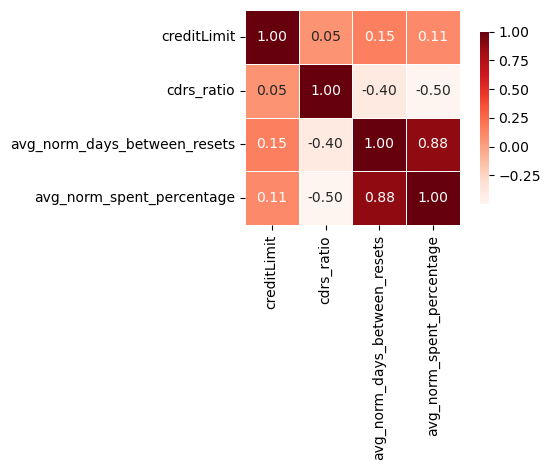

In [10]:
pltUtils.plot_correlation_heatmap(stability_stats_full, ['creditLimit', 'cdrs_ratio', 'avg_norm_days_between_resets', 'avg_norm_spent_percentage'], cmap="Reds")

### Check how many accounts where two key variables (`avg_norm_days_between_resets` and `avg_norm_spent_percentage`) are missing and also how many transactions these accounts have in the main dataset

In [11]:
both_avg_stats_is_na_accounts = stability_stats_full[(stability_stats_full['avg_norm_days_between_resets'].isnull()) & (
    stability_stats_full['avg_norm_spent_percentage'].isnull())]['accountNumber']
stab_df_both_avg_stats_is_na_accounts = stability_stats_full[
    stability_stats_full['accountNumber'].isin(both_avg_stats_is_na_accounts)]

gen_df_with_both_invalid_avg_stats = df[df['accountNumber'].isin(both_avg_stats_is_na_accounts)]
print(
    f'Count of account transactions where both necessary params avg (spent percentage, avg days btw resets) is nan in stability stats: {gen_df_with_both_invalid_avg_stats.shape[0]}')
edaUtils.calculate_percentage(gen_df_with_both_invalid_avg_stats.shape[0], df.shape[0])
print(
    f'Count of frauds transactions in gen dataset by these account numbers: {gen_df_with_both_invalid_avg_stats[gen_df_with_both_invalid_avg_stats["isFraud"] == True].shape[0]}')

Count of account transactions where both necessary params avg (spent percentage, avg days btw resets) is nan in stability stats: 573
Number 573 is 0.06701527082707136% of 855029
Count of frauds transactions in gen dataset by these account numbers: 0


### Remove accounts that are missing two key variables (`avg_norm_days_between_resets` and `avg_norm_spent_percentage`) from the dataset for the submodel for predicting the coefficient, as well as remove transactions of these accounts from the main dataset

In [12]:
df.drop(index=gen_df_with_both_invalid_avg_stats.index, inplace=True)
stability_stats_full.drop(index=stab_df_both_avg_stats_is_na_accounts.index, inplace=True)
edaUtils.data_summary(stability_stats_full)

Dimensions: 4959 rows, 6 columns
Total NA's: 5164
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     4959            0         
creditLimit                            float64    10              0         
avg_norm_spent_percentage              float64    3740            1         
avg_norm_days_between_resets           float64    3133            55        
cdrs_ratio                             float64    2138            2403      
cdrs_range                             category   7               2705      


### Check how many accounts where two variable`avg_norm_spent_percentage` is missing and also how many transactions these accounts have in the main dataset

In [13]:
stab_df_invalid_spent_avg_stats_is_na_accounts = \
    stability_stats_full[stability_stats_full['avg_norm_spent_percentage'].isnull()]['accountNumber']
gen_df_with_invalid_spent_avg_stats = df[df['accountNumber'].isin(stab_df_invalid_spent_avg_stats_is_na_accounts)]

print(
    f'Count of account transactions where avg spent percentage btw resets in nan in stability stats: {gen_df_with_invalid_spent_avg_stats.shape[0]}')
edaUtils.calculate_percentage(gen_df_with_invalid_spent_avg_stats.shape[0], df.shape[0])
print(
    f'Count of frauds transactions in gen dataset by these account numbers: {gen_df_with_invalid_spent_avg_stats[gen_df_with_invalid_spent_avg_stats["isFraud"] == True].shape[0]}')

Count of account transactions where avg spent percentage btw resets in nan in stability stats: 12
Number 12 is 0.0014044023331804096% of 854456
Count of frauds transactions in gen dataset by these account numbers: 0


In [14]:
df[df['accountNumber'] == '259711806']

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,transactionType,creditDebt,cardPresent,expirationDateKeyInMatch,isFraud,creditLimitRange
154120,259711806,20000.0,20000.00,2016-09-13 09:44:41.000,20000.00,US,US,05,01,mobileapps,...,2010-05-10,2010-05-10,784,784,REPLENISHMENT,0.00,False,False,False,75-100%
154121,259711806,20000.0,20000.00,2016-09-14 09:44:41.000,6.58,US,US,05,01,mobileapps,...,2010-05-10,2010-05-10,784,784,PURCHASE,0.00,False,False,False,75-100%
154122,259711806,20000.0,19993.42,2016-09-16 22:04:48.000,10.80,US,US,05,01,online_subscriptions,...,2010-05-10,2010-05-10,784,787,PURCHASE,6.58,False,False,False,75-100%
154123,259711806,20000.0,19982.62,2016-10-01 10:43:33.500,17.38,US,US,05,01,online_subscriptions,...,2010-05-10,2010-05-10,784,784,REPLENISHMENT,17.38,False,False,False,75-100%
154124,259711806,20000.0,20000.00,2016-10-15 23:22:19.000,6.58,US,US,05,01,mobileapps,...,2010-05-10,2010-05-10,784,784,PURCHASE,0.00,False,False,False,75-100%
154125,259711806,20000.0,19993.42,2016-10-17 06:06:18.000,10.80,US,US,05,01,online_subscriptions,...,2010-05-10,2010-05-10,784,787,PURCHASE,6.58,False,False,False,75-100%
154126,259711806,20000.0,19982.62,2016-11-01 01:46:42.000,17.38,US,US,05,01,online_subscriptions,...,2010-05-10,2010-05-10,784,784,REPLENISHMENT,17.38,False,False,False,75-100%
154127,259711806,20000.0,20000.00,2016-11-15 21:27:06.000,6.58,US,US,05,01,mobileapps,...,2010-05-10,2010-05-10,784,784,PURCHASE,0.00,False,False,False,75-100%
154128,259711806,20000.0,19993.42,2016-11-16 08:33:18.000,10.80,US,US,05,01,online_subscriptions,...,2010-05-10,2010-05-10,784,787,PURCHASE,6.58,False,False,False,75-100%
154129,259711806,20000.0,19982.62,2016-12-01 21:12:57.000,17.38,US,US,05,01,online_subscriptions,...,2010-05-10,2010-05-10,784,784,REPLENISHMENT,17.38,False,False,False,75-100%


### Remove accounts that is missing key variable `avg_norm_spent_percentage` from the dataset for the submodel for predicting the coefficient, as well as remove transactions of these accounts from the main dataset

In [15]:
df.drop(index=gen_df_with_invalid_spent_avg_stats.index, inplace=True)
stability_stats_full.drop(index=stab_df_invalid_spent_avg_stats_is_na_accounts.index, inplace=True)
edaUtils.data_summary(stability_stats_full)

Dimensions: 4958 rows, 6 columns
Total NA's: 5161
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     4958            0         
creditLimit                            float64    10              0         
avg_norm_spent_percentage              float64    3740            0         
avg_norm_days_between_resets           float64    3133            55        
cdrs_ratio                             float64    2138            2402      
cdrs_range                             category   7               2704      


### Check how many accounts where two variable`avg_norm_days_between_resets` is missing and also how many transactions these accounts have in the main dataset

In [16]:
days_avg_stat_is_na_accounts = stability_stats_full[stability_stats_full['avg_norm_days_between_resets'].isnull()][
    'accountNumber']
stab_df_days_avg_stats_is_na_accounts = stability_stats_full[
    stability_stats_full['accountNumber'].isin(days_avg_stat_is_na_accounts)]

gen_df_with_invalid_days_avg_stats = df[df['accountNumber'].isin(days_avg_stat_is_na_accounts)]
print(
    f'Count of account transactions where avg days btw resets in nan in stability stats: {gen_df_with_invalid_days_avg_stats.shape[0]}')
edaUtils.calculate_percentage(gen_df_with_invalid_days_avg_stats.shape[0], df.shape[0])
print(
    f'Count of frauds transactions in gen dataset by these account numbers: {gen_df_with_invalid_days_avg_stats[gen_df_with_invalid_days_avg_stats["isFraud"] == True].shape[0]}')

edaUtils.calculate_percentage(gen_df_with_invalid_days_avg_stats[gen_df_with_invalid_days_avg_stats["isFraud"] == True].shape[0], df[df['isFraud'] == True].shape[0])

Count of account transactions where avg days btw resets in nan in stability stats: 35127
Number 35127 is 4.111094466108955% of 854444
Count of frauds transactions in gen dataset by these account numbers: 787
Number 787 is 6.3380848836272845% of 12417


In [17]:
df[df['accountNumber'] == '155977598']

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,transactionType,creditDebt,cardPresent,expirationDateKeyInMatch,isFraud,creditLimitRange
51651,155977598,5000.0,5000.00,2016-02-27 15:29:21.000,5000.00,US,US,05,01,online_subscriptions,...,2012-08-12,2012-08-12,424,424,REPLENISHMENT,0.00,False,False,False,0-25%
51652,155977598,5000.0,5000.00,2016-02-28 15:29:21.000,22.35,US,US,05,01,online_subscriptions,...,2012-08-12,2012-08-12,424,424,PURCHASE,0.00,False,False,False,0-25%
51653,155977598,5000.0,4977.65,2016-03-14 20:19:49.500,22.35,US,US,05,01,online_subscriptions,...,2012-08-12,2012-08-12,424,424,REPLENISHMENT,22.35,False,False,False,0-25%
51654,155977598,5000.0,5000.00,2016-03-30 01:10:18.000,22.35,US,US,05,01,online_subscriptions,...,2012-08-12,2012-08-12,424,424,PURCHASE,0.00,False,False,False,0-25%
51655,155977598,5000.0,4977.65,2016-04-14 13:23:21.500,22.35,US,US,05,01,online_subscriptions,...,2012-08-12,2012-08-12,424,424,REPLENISHMENT,22.35,False,False,False,0-25%
51656,155977598,5000.0,5000.00,2016-04-30 01:36:25.000,22.35,US,US,05,01,online_subscriptions,...,2012-08-12,2012-08-12,424,424,PURCHASE,0.00,False,False,False,0-25%
51657,155977598,5000.0,4977.65,2016-05-15 10:36:07.500,22.35,US,US,05,01,online_subscriptions,...,2012-08-12,2012-08-12,424,424,REPLENISHMENT,22.35,False,False,False,0-25%
51658,155977598,5000.0,5000.00,2016-05-30 19:35:50.000,22.35,US,US,05,01,online_subscriptions,...,2012-08-12,2012-08-12,424,424,PURCHASE,0.00,False,False,False,0-25%
51659,155977598,5000.0,4977.65,2016-06-14 15:05:05.500,22.35,US,US,05,01,online_subscriptions,...,2012-08-12,2012-08-12,424,424,REPLENISHMENT,22.35,False,False,False,0-25%
51660,155977598,5000.0,5000.00,2016-06-29 10:34:21.000,34.55,US,US,02,08,food,...,2012-08-12,2012-08-12,424,424,PURCHASE,0.00,True,False,False,0-25%


### Remove accounts that is missing key variable `avg_norm_days_between_resets` from the dataset for the submodel for predicting the coefficient, as well as remove transactions of these accounts from the main dataset

In [18]:
df.drop(index=gen_df_with_invalid_days_avg_stats.index, inplace=True)
stability_stats_full.drop(index=stab_df_days_avg_stats_is_na_accounts.index, inplace=True)
edaUtils.data_summary(stability_stats_full)

Dimensions: 4903 rows, 6 columns
Total NA's: 5000
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     4903            0         
creditLimit                            float64    10              0         
avg_norm_spent_percentage              float64    3711            0         
avg_norm_days_between_resets           float64    3133            0         
cdrs_ratio                             float64    2137            2349      
cdrs_range                             category   7               2651      


### Check how many accounts where `cdrs_ratio` equals `0` and also how many transactions these accounts have in the main dataset

In [19]:
cdrs_ratio_is_0_accounts = stability_stats_full[stability_stats_full['cdrs_ratio'] == 0]['accountNumber']
stab_df_cdrs_ratio_is_0 = stability_stats_full[stability_stats_full['accountNumber'].isin(cdrs_ratio_is_0_accounts)]

gen_df_cdrs_ratio_is_0 = df[df['accountNumber'].isin(cdrs_ratio_is_0_accounts)]
print(f'Count of account transactions where cdrs ratio is 0 in stability stats: {gen_df_cdrs_ratio_is_0.shape[0]}')
edaUtils.calculate_percentage(gen_df_cdrs_ratio_is_0.shape[0], df.shape[0])
print(
    f'Count of frauds transactions in gen dataset by these account numbers: {gen_df_cdrs_ratio_is_0[gen_df_cdrs_ratio_is_0["isFraud"] == True].shape[0]}')

edaUtils.calculate_percentage(gen_df_cdrs_ratio_is_0[gen_df_cdrs_ratio_is_0["isFraud"] == True].shape[0],
                              df[df['isFraud'] == True].shape[0])

Count of account transactions where cdrs ratio is 0 in stability stats: 70503
Number 70503 is 8.605094243131779% of 819317
Count of frauds transactions in gen dataset by these account numbers: 1011
Number 1011 is 8.693035253654342% of 11630


### Remove accounts that is `cdrs_ratio` equals `0` from the dataset for the submodel for predicting the coefficient, as well as remove transactions of these accounts from the main dataset

In [20]:
df.drop(index=gen_df_cdrs_ratio_is_0.index, inplace=True)
stability_stats_full.drop(index=cdrs_ratio_is_0_accounts.index, inplace=True)
edaUtils.data_summary(stability_stats_full)

Dimensions: 4601 rows, 6 columns
Total NA's: 4698
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     4601            0         
creditLimit                            float64    10              0         
avg_norm_spent_percentage              float64    3505            0         
avg_norm_days_between_resets           float64    2965            0         
cdrs_ratio                             float64    2136            2349      
cdrs_range                             category   7               2349      


### Encode target feature for out submodel - `cdrs_range`

In [21]:
stability_stats_full_test_pred_df = stability_stats_full.copy()
stability_stats_full_test_pred_df.dropna(inplace=True)
cdrs_range_encoder = LabelEncoder()

stability_stats_full_test_pred_df['cdrs_range_encoded'] = cdrs_range_encoder.fit_transform(
    stability_stats_full_test_pred_df['cdrs_range'])
edaUtils.data_summary(stability_stats_full_test_pred_df)


Dimensions: 2252 rows, 7 columns
Total NA's: 0
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     2252            0         
creditLimit                            float64    10              0         
avg_norm_spent_percentage              float64    2221            0         
avg_norm_days_between_resets           float64    1848            0         
cdrs_ratio                             float64    2136            0         
cdrs_range                             category   7               0         
cdrs_range_encoded                     int32      7               0         


### Split data for cdrs-predicting submodel

In [22]:
X_stats_full = stability_stats_full_test_pred_df.drop(
    columns=['cdrs_range', 'cdrs_range_encoded', 'cdrs_ratio', 'accountNumber'])
Y_stats_full = stability_stats_full_test_pred_df['cdrs_range_encoded']

X_stats_full_train, X_stats_full_test, Y_stats_full_train, Y_stats_full_test = train_test_split(X_stats_full,
                                                                                                Y_stats_full,
                                                                                                test_size=0.2,
                                                                                                random_state=101)

### Check data balance for cdrs-predicting submodel

In [23]:
cdrs_range_encoded_weights = compute_class_weight('balanced', classes=Y_stats_full_train.unique(), y=Y_stats_full_train)
print(f'Cdrs range distribution weights in train dataset {cdrs_range_encoded_weights}')

Cdrs range distribution weights in train dataset [18.37755102  0.62752613  0.35684565  0.44901521  3.38533835 64.32142857
 85.76190476]


### Train CDRS-ratio predicting model

In [24]:
cdrs_range_best_model, cdrs_trained_models = mteUtils.load_or_tune_and_evaluate_models('cdrs_ratio_predictor', mteUtils.models_dictionary, X_stats_full_train, X_stats_full_test, Y_stats_full_train, Y_stats_full_test, re_train=False)

------------------------------
Starting tuning for model: LogisticRegression


C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:246: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/prepr

C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:246: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:246: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:246: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:246: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/prepr

C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:246: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:246: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:246: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:246: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:246: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/prepr

C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:246: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Model LogisticRegression has been fitted!
Predictions made for LogisticRegression!
Best parameters for LogisticRegression: {'C': 10, 'solver': 'newton-cg'}
Accuracy for LogisticRegression: 74.72%
Model tuning time for LogisticRegression: 4.90 seconds
------------------------------
Starting tuning for model: GaussianNB
Model GaussianNB has been fitted!
Predictions made for GaussianNB!
Best parameters for GaussianNB: {'var_smoothing': 1e-09}
Accuracy for GaussianNB: 47.67%
Model tuning time for GaussianNB: 0.08 seconds
------------------------------
Starting tuning for model: KNeighborsClassifier


Model KNeighborsClassifier has been fitted!
Predictions made for KNeighborsClassifier!
Best parameters for KNeighborsClassifier: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy for KNeighborsClassifier: 78.27%
Model tuning time for KNeighborsClassifier: 1.08 seconds
------------------------------
Starting tuning for model: RandomForest


C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Model RandomForest has been fitted!
Predictions made for RandomForest!
Best parameters for RandomForest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy for RandomForest: 80.71%
Model tuning time for RandomForest: 43.63 seconds
------------------------------
Starting tuning for model: DecisionTreeClassifier


C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Model DecisionTreeClassifier has been fitted!
Predictions made for DecisionTreeClassifier!
Best parameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 6}
Accuracy for DecisionTreeClassifier: 77.16%
Model tuning time for DecisionTreeClassifier: 26.38 seconds
Model storage folder created or already exists: ../../model/saved/cdrs_ratio_predictor
Objects successfully serialized into ../../model/saved/cdrs_ratio_predictor\cdrs_ratio_predictor_best.pkl
Objects successfully serialized into ../../model/saved/cdrs_ratio_predictor\cdrs_ratio_predictor_all.pkl
Models for cdrs_ratio_predictor saved successfully.
Best model is RandomForest with an accuracy of 80.71%
Total hyper-parameter tuning time: 76.12 seconds for all models


### Evaluate CDRS-ratio predicting model

In [25]:
mteUtils.evaluate_models(cdrs_trained_models, Y_stats_full_test)

ERROR:utils.ModelTrainingAndEvaluationUtils:[LogisticRegression] Error calculating ROC AUC: axis 1 is out of bounds for array of dimension 1


C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
ERROR:utils.ModelTrainingAndEvaluationUtils:[GaussianNB] Error calculating ROC AUC: axis 1 is out of bounds for array of dimension 1


C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
ERROR:utils.ModelTrainingAndEvaluationUtils:[KNeighborsClassifier] Error calculating ROC AUC: axis 1 is out of bounds for array of dimension 1


C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
ERROR:utils.ModelTrainingAndEvaluationUtils:[RandomForest] Error calculating ROC AUC: axis 1 is out of bounds for array of dimension 1


C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
ERROR:utils.ModelTrainingAndEvaluationUtils:[DecisionTreeClassifier] Error calculating ROC AUC: axis 1 is out of bounds for array of dimension 1


Model Name           Accuracy   ROC AUC    Precision  Recall     F1 Score  
LogisticRegression   0.75       N/A        0.71       0.75       0.72      
GaussianNB           0.48       N/A        0.46       0.48       0.39      
KNeighborsClassifier 0.78       N/A        0.78       0.78       0.77      
RandomForest         0.81       N/A        0.81       0.81       0.80      
DecisionTreeClassifier 0.77       N/A        0.77       0.77       0.77      


C:\Users\gorba\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Show confusion matrix for CDRS-ratio predicting model

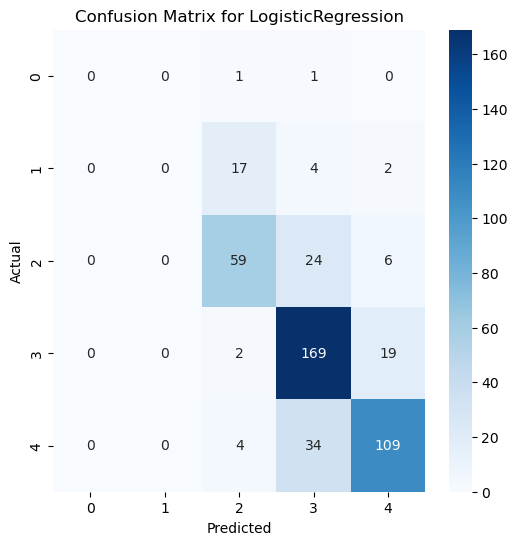

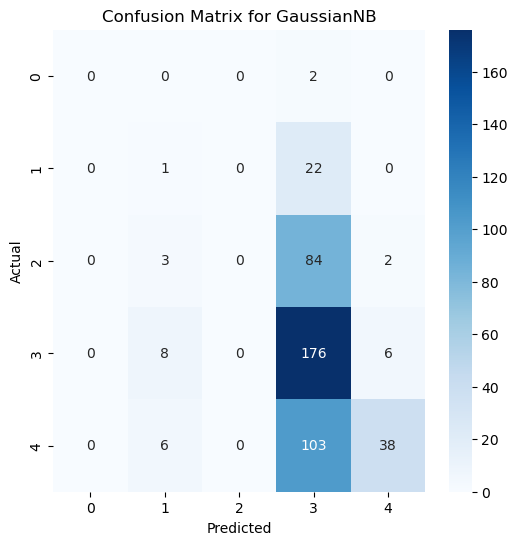

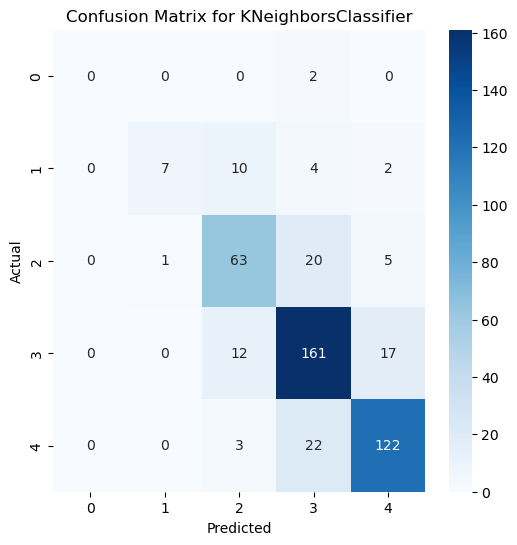

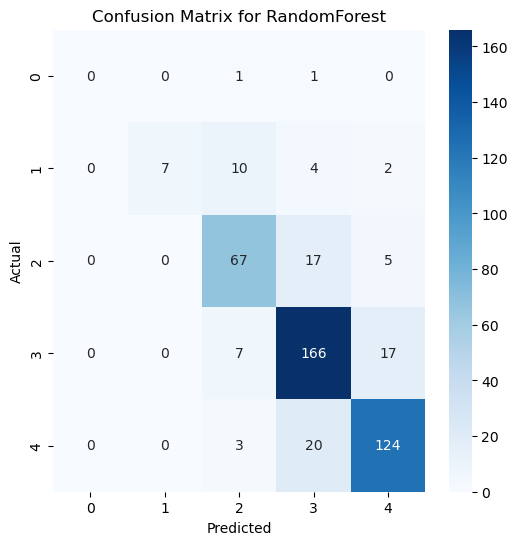

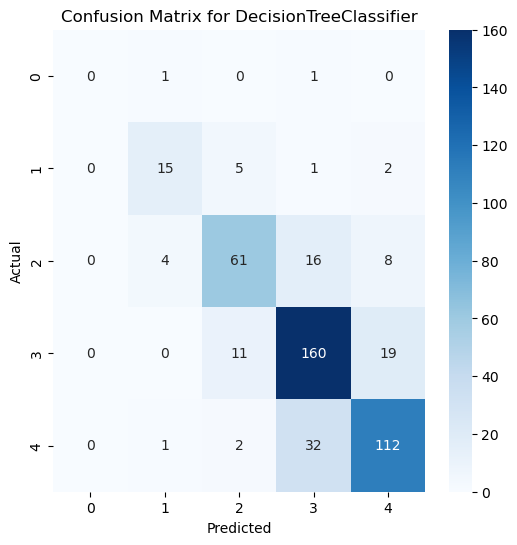

In [26]:
pltUtils.plot_confusion_matrix_models(models=cdrs_trained_models, X_test=X_stats_full_test, Y_test=Y_stats_full_test)

### Show feature importance matrix for CDRS-ratio predicting model

The model 'LogisticRegression' does not support feature importance plotting.
The model 'GaussianNB' does not support feature importance plotting.
The model 'KNeighborsClassifier' does not support feature importance plotting.


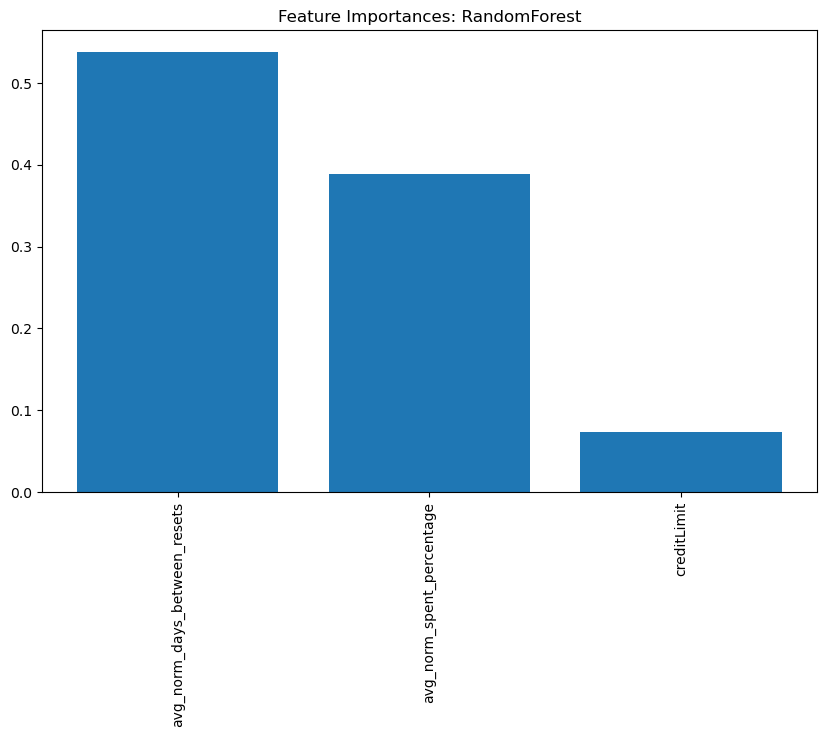

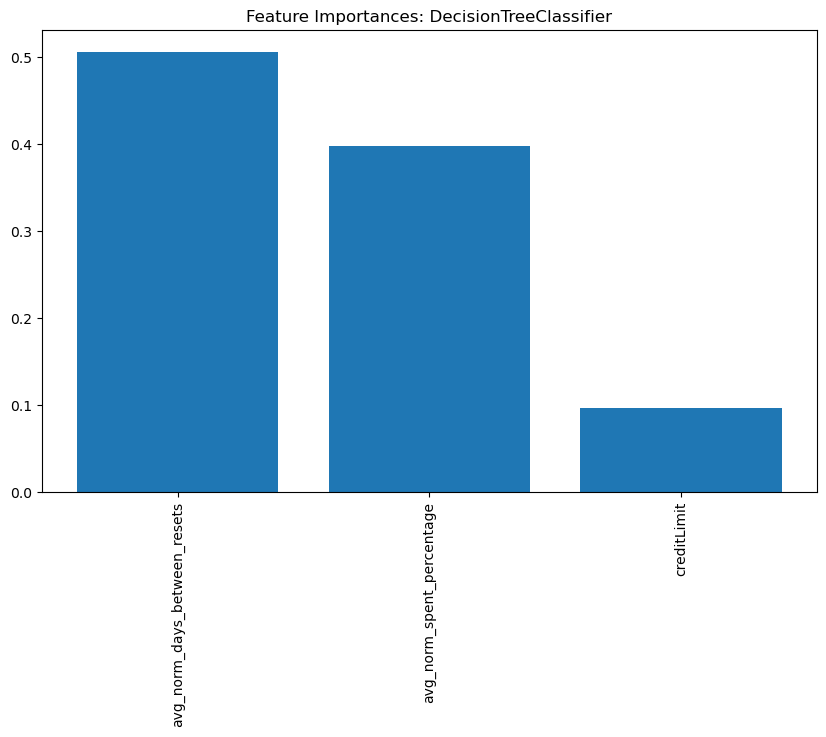

In [27]:
pltUtils.plot_feature_importances(models=cdrs_trained_models, feature_names=list(X_stats_full_test.columns))

### Check N/A values in dataset for CDRS-ratio predicting model

In [28]:
edaUtils.data_summary(stability_stats_full)

Dimensions: 4601 rows, 6 columns
Total NA's: 4698
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     4601            0         
creditLimit                            float64    10              0         
avg_norm_spent_percentage              float64    3505            0         
avg_norm_days_between_resets           float64    2965            0         
cdrs_ratio                             float64    2136            2349      
cdrs_range                             category   7               2349      


### Fill skipped CDRS ratio by predicted value by out submodel
Fill in the missing values of the coefficient ranges for each account with the values that were predicted by our submodel. And the coefficient itself is filled in this way, the value of the predicted range is taken, across the entire data set the average number for those accounts with the same range is taken and assigned to the coefficient column.

In [29]:
empty_cdrs_ratio_accounts = stability_stats_full[stability_stats_full['cdrs_range'].isnull()]
data_for_cdrs_range_prediction = empty_cdrs_ratio_accounts.drop(columns=['cdrs_ratio', 'cdrs_range', 'accountNumber'])
encoded_predicted_cdrs_range = cdrs_range_best_model.predict(data_for_cdrs_range_prediction)
empty_cdrs_ratio_accounts['cdrs_range'] = cdrs_range_encoder.inverse_transform(encoded_predicted_cdrs_range)

mean_cdrs_ratio_per_range = stability_stats_full[stability_stats_full['cdrs_range'].notna()].groupby('cdrs_range')['cdrs_ratio'].mean()
def fill_na_with_mean(row):
    if pd.isna(row['cdrs_ratio']):
        return mean_cdrs_ratio_per_range[row['cdrs_range']]
    else:
        return row['cdrs_ratio']

empty_cdrs_ratio_accounts['cdrs_ratio'] = empty_cdrs_ratio_accounts.apply(fill_na_with_mean, axis=1)

stability_stats_full.loc[
    stability_stats_full['accountNumber'].isin(empty_cdrs_ratio_accounts['accountNumber']),
    ['cdrs_range', 'cdrs_ratio']
] = empty_cdrs_ratio_accounts[['cdrs_range', 'cdrs_ratio']].values

stability_stats_full


C:\Users\gorba\AppData\Local\Temp\ipykernel_18580\2594833477.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_cdrs_ratio_accounts['cdrs_range'] = cdrs_range_encoder.inverse_transform(encoded_predicted_cdrs_range)
C:\Users\gorba\AppData\Local\Temp\ipykernel_18580\2594833477.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_cdrs_ratio_per_range = stability_stats_full[stability_stats_full['cdrs_range'].notna()].groupby('cdrs_range')['cdrs_ratio'].mean()
C:\Users\gorba\AppData\Local\Temp\ipykernel_18580\2594833477.py:13: SettingWithCopyWarning: 


,accountNumber,creditLimit,avg_norm_spent_percentage,avg_norm_days_between_resets,cdrs_ratio,cdrs_range
0,100088067,50000.0,0.271256,0.740260,0.799200,"(0.778, 0.889]"
1,100108752,5000.0,1.000000,1.000000,0.504463,"(0.444, 0.556]"
2,100328049,5000.0,0.488997,0.681818,0.666593,"(0.556, 0.667]"
3,100663626,20000.0,0.500000,0.500000,0.734987,"(0.667, 0.778]"
4,100737756,250.0,0.127899,0.121490,0.926386,"(0.889, 1.0]"
...,...,...,...,...,...,...
4994,998869994,7500.0,1.000000,1.000000,0.504463,"(0.444, 0.556]"
4996,999257059,15000.0,0.375245,0.266667,0.899935,"(0.889, 1.0]"
4997,999258704,5000.0,0.442661,0.251220,0.888795,"(0.778, 0.889]"
4998,999283629,2500.0,0.534500,0.726790,0.712807,"(0.667, 0.778]"


### Final data summary for our submodel with the data already filled in

In [30]:
edaUtils.data_summary(stability_stats_full)

Dimensions: 4601 rows, 6 columns
Total NA's: 0
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     4601            0         
creditLimit                            float64    10              0         
avg_norm_spent_percentage              float64    3505            0         
avg_norm_days_between_resets           float64    2965            0         
cdrs_ratio                             float64    2141            0         
cdrs_range                             category   7               0         


C:\Users\gorba\AppData\Local\Temp\ipykernel_18580\3747772818.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_stats = df_merged.groupby('cdrs_range').agg(


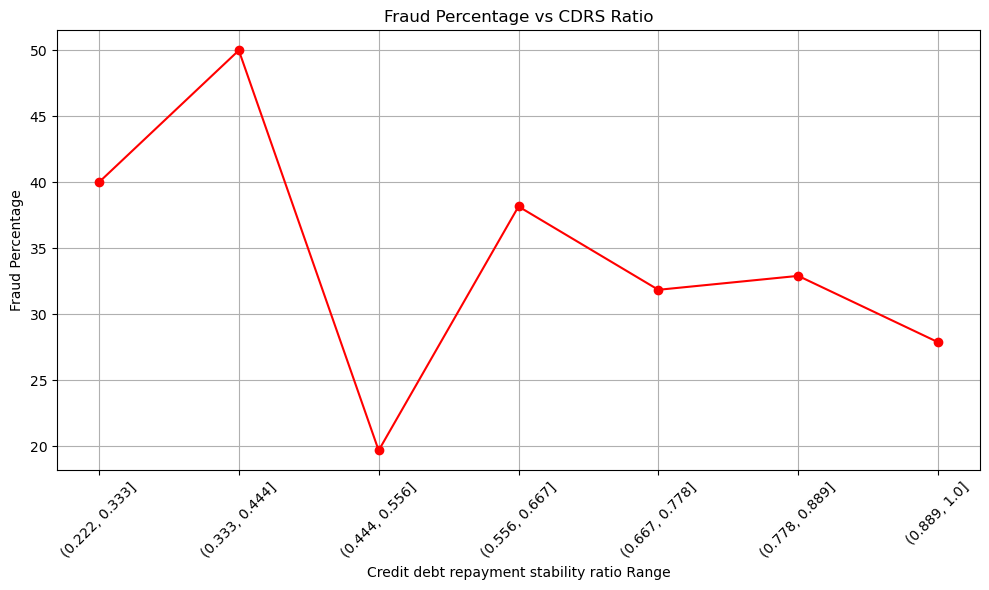

In [31]:
visualize_fraud_vs_cdrs_ratio(calculate_fraud_stats(df, stability_stats_full))

#### Add cdrs ratio and range to general dataset and drop synthetic replenishment transactions

In [32]:
cdrs_ratio_data = stability_stats_full[['accountNumber', 'cdrs_ratio', 'cdrs_range']]
df = df.merge(cdrs_ratio_data, on='accountNumber', how='left')
df = df[df['transactionType'] != 'REPLENISHMENT']
df.head()

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,...,cardCVV,enteredCVV,transactionType,creditDebt,cardPresent,expirationDateKeyInMatch,isFraud,creditLimitRange,cdrs_ratio,cdrs_range
1,100088067,50000.0,50000.00,2016-01-12 00:59:52,205.13,US,US,02,01,entertainment,...,546,546,PURCHASE,0.00,True,False,False,75-100%,0.7992,"(0.778, 0.889]"
2,100088067,50000.0,49794.87,2016-01-12 19:49:41,46.43,US,US,05,01,food,...,546,546,PURCHASE,205.13,True,False,False,75-100%,0.7992,"(0.778, 0.889]"
3,100088067,50000.0,49748.44,2016-01-17 15:41:46,378.67,US,US,05,01,online_gifts,...,402,402,PURCHASE,251.56,False,False,False,75-100%,0.7992,"(0.778, 0.889]"
5,100088067,50000.0,50000.00,2016-02-02 19:57:18,66.07,US,US,02,01,entertainment,...,546,546,PURCHASE,0.00,True,False,False,75-100%,0.7992,"(0.778, 0.889]"
6,100088067,50000.0,49933.93,2016-02-03 04:48:54,141.60,US,US,09,08,food,...,546,546,PURCHASE,66.07,True,False,False,75-100%,0.7992,"(0.778, 0.889]"


In [33]:
edaUtils.data_summary(df)

Dimensions: 685917 rows, 23 columns
Total NA's: 0
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     4601            0         
creditLimit                            float64    10              0         
availableMoney                         float64    475773          0         
transactionDateTime                    datetime64[ns] 678509          0         
transactionAmount                      float64    63846           0         
acqCountry                             object     4               0         
merchantCountryCode                    object     4               0         
posEntryMode                           object     5               0         
posConditionCode                       object     3               0         
merchantCategoryCode                   object     19              0         
currentExpDate                         datetime64[ns] 165 

### Creating a new feature (MATCH ENTERED CVV OR NOT)

In [34]:
df['cvv_matched_status'] = [True if actual_cvv == entered_cvv else False for actual_cvv, entered_cvv in zip(df['cardCVV'], df['enteredCVV'])]
df.drop(columns=['cardCVV', 'enteredCVV'], inplace=True)
edaUtils.data_summary(df)

Dimensions: 685917 rows, 22 columns
Total NA's: 0
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     4601            0         
creditLimit                            float64    10              0         
availableMoney                         float64    475773          0         
transactionDateTime                    datetime64[ns] 678509          0         
transactionAmount                      float64    63846           0         
acqCountry                             object     4               0         
merchantCountryCode                    object     4               0         
posEntryMode                           object     5               0         
posConditionCode                       object     3               0         
merchantCategoryCode                   object     19              0         
currentExpDate                         datetime64[ns] 165 

### Creating a new feature (Address change count)

In [35]:
def add_address_change_count_column(df):
    """
    Adds a new column 'addressChangeCount' to the DataFrame with the number of address changes
    per account up to the time of each transaction.

    Parameters:
    df (pd.DataFrame): The dataset containing transactions.

    Returns:
    pd.DataFrame: Updated DataFrame with the new 'addressChangeCount' column.
    """
    # Convert columns with dates to datetime format
    df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'])
    df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])

    # Sort by accountNumber and transactionDateTime to ensure correct order
    df = df.sort_values(by=['accountNumber', 'transactionDateTime'])

    # Initialize a new column for address change count
    df['addressChangeCount'] = 0

    # Group by account number to process each account's transactions individually
    for account, group in df.groupby('accountNumber'):
        address_changes = 0
        last_change_date = None

        # Iterate through each transaction for the account
        for idx, row in group.iterrows():
            # Check if the current transaction date is after the last address change
            if last_change_date is None or row['dateOfLastAddressChange'] > last_change_date:
                address_changes += 1
                last_change_date = row['dateOfLastAddressChange']

            # Set the count of address changes up to the current transaction
            df.at[idx, 'addressChangeCount'] = address_changes - 1

    return df

In [36]:
df = stage_data_io_service.run_or_load_snapshot_data('add_address_change_count_column', add_address_change_count_column, df, recreate_snapshot=False)

Processing add_address_change_count_column...


In [37]:
edaUtils.data_summary(df)

Dimensions: 685917 rows, 23 columns
Total NA's: 0
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     4601            0         
creditLimit                            float64    10              0         
availableMoney                         float64    475773          0         
transactionDateTime                    datetime64[ns] 678509          0         
transactionAmount                      float64    63846           0         
acqCountry                             object     4               0         
merchantCountryCode                    object     4               0         
posEntryMode                           object     5               0         
posConditionCode                       object     3               0         
merchantCategoryCode                   object     19              0         
currentExpDate                         datetime64[ns] 165 

### Creating a new feature (Suspicious transaction flag)

In [38]:
def find_suspicious_transactions(df, time_threshold_milliseconds):
    """
    Identify suspicious transactions within a specified time threshold.

    Parameters:
    df (pd.DataFrame): The transaction dataset, which includes 'accountNumber', 'transactionDateTime', and 'transactionAmount'.
    time_threshold_milliseconds (int): The time window in milliseconds within which multiple transactions of the same amount are flagged as suspicious.

    Returns:
    pd.DataFrame: The original DataFrame with an additional 'is_suspicious' column.
    """
    # Sort by 'accountNumber' and 'transactionDateTime' to arrange transactions chronologically by account
    df = df.sort_values(['accountNumber', 'transactionDateTime']).reset_index(drop=True)
    
    # Check for duplicate transaction amounts for each account using `transform` to maintain DataFrame shape
    is_duplicate_amount = df.groupby('accountNumber')['transactionAmount'].transform(lambda x: x.duplicated())
    
    # Calculate time difference between consecutive transactions for each account in milliseconds
    is_within_time_threshold = df.groupby('accountNumber')['transactionDateTime'].diff() <= pd.Timedelta(time_threshold_milliseconds, unit='milliseconds')
    
    # Combine conditions: duplicate amount and time difference within threshold
    df["is_suspicious"] = is_duplicate_amount & is_within_time_threshold
    
    return df

In [39]:
df = find_suspicious_transactions(df, time_threshold_milliseconds=3 * 60 * 1000)
suspicious_df = df[df['is_suspicious'] == True]

print("Total number of suspicious transactions: {}".format(suspicious_df.shape[0]))
print("Total transaction amount of suspicious transactions: {}$".format(round(suspicious_df['transactionAmount'].sum(), 2)))
edaUtils.data_summary(df)

Total number of suspicious transactions: 12325
Total transaction amount of suspicious transactions: 1722028.56$


Dimensions: 685917 rows, 24 columns
Total NA's: 0
There are no duplicates in this dataset!
Column Name                            Data Type  Count Distinct  NA Values 
accountNumber                          object     4601            0         
creditLimit                            float64    10              0         
availableMoney                         float64    475773          0         
transactionDateTime                    datetime64[ns] 678509          0         
transactionAmount                      float64    63846           0         
acqCountry                             object     4               0         
merchantCountryCode                    object     4               0         
posEntryMode                           object     5               0         
posConditionCode                       object     3               0         
merchantCategoryCode                   object     19              0         
currentExpDate                         datetime64[ns] 165 

## Preparing df for Model building

### Select necessary features for model

In [40]:
fraud_modelling_df = df.drop(columns=[
    'accountNumber',
    'transactionDateTime',
    'currentExpDate',
    'accountOpenDate',
    'dateOfLastAddressChange'
])
fraud_modelling_df.columns

Index(['creditLimit', 'availableMoney', 'transactionAmount', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'transactionType', 'creditDebt', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud', 'creditLimitRange', 'cdrs_ratio',
       'cdrs_range', 'cvv_matched_status', 'addressChangeCount',
       'is_suspicious'],
      dtype='object')

### Encode categorical features

In [41]:
fraud_modelling_df, encoders = dtUtils.encode_categorical_columns(fraud_modelling_df, [
    'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'transactionType', 'creditLimitRange', 'cdrs_range'
])

### Transform boolean features to numeric

In [42]:
fraud_modelling_df = dtUtils.convert_bool_columns_to_int(fraud_modelling_df, ['cardPresent', 'expirationDateKeyInMatch', 'isFraud', 'cvv_matched_status', 'is_suspicious'])

### Split the data in such a way that both the training and test sets include the number of records with the `isFraud=True` flag, corresponding to the `test_size` coefficient

In [43]:
def custom_train_test_split(data, target_column, test_size=0.2, random_state=None):
    # Separate fraud and non-fraud cases
    fraud_data = data[data[target_column] == True]
    non_fraud_data = data[data[target_column] == False]
    
    # Split fraud cases equally between train and test
    fraud_train, fraud_test = train_test_split(
        fraud_data, 
        test_size=test_size, 
        random_state=random_state
    )
    
    # Split non-fraud cases randomly based on test_size
    non_fraud_train, non_fraud_test = train_test_split(
        non_fraud_data, 
        test_size=test_size, 
        random_state=random_state
    )
    
    # Combine train and test splits
    train_data = pd.concat([fraud_train, non_fraud_train]).sample(frac=1, random_state=random_state)
    test_data = pd.concat([fraud_test, non_fraud_test]).sample(frac=1, random_state=random_state)
    
    # Separate features and target
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]
    X_test = test_data.drop(columns=[target_column])
    y_test = test_data[target_column]
    
    return X_train, X_test, y_train, y_test

In [44]:
X_train, X_test, Y_train, Y_test = custom_train_test_split(fraud_modelling_df, target_column="isFraud", test_size=0.2, random_state=42)

print(f"Train size: {len(X_train)} (Fraud count: {sum(Y_train)})")
print(f"Test size: {len(X_test)} (Fraud count: {sum(Y_test)})")

Train size: 548733 (Fraud count: 8495)
Test size: 137184 (Fraud count: 2124)


### Check train dataset fraud distribution

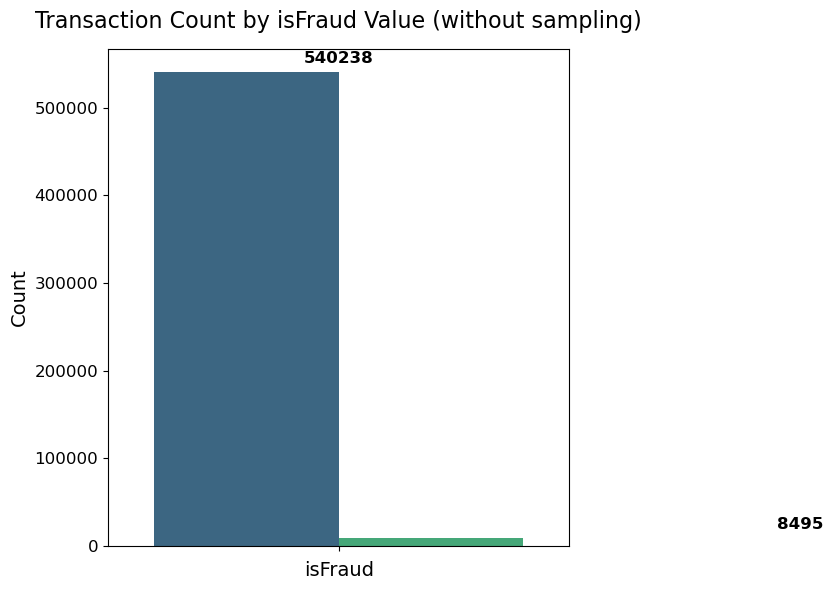

In [45]:
pltUtils.plot_barplot_distribution(Y_train, 'Transaction Count by isFraud Value (without sampling)')

### Apply the undersampling technique on the training dataset

In [46]:
X_train, Y_train = dtUtils.sample_features_target(X_train, Y_train, method='undersample')

### Check train dataset fraud distribution after undersampling

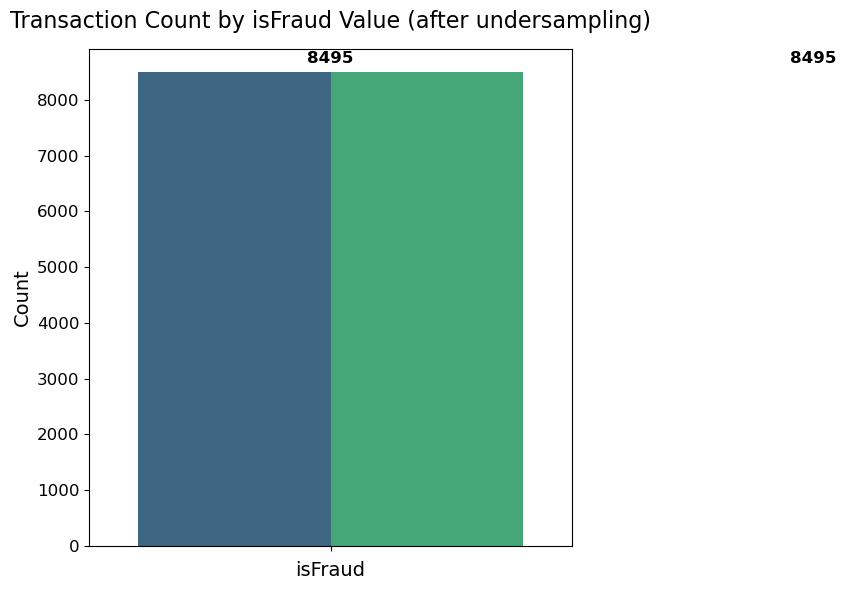

In [47]:
pltUtils.plot_barplot_distribution(Y_train, 'Transaction Count by isFraud Value (after undersampling)')

## Save stage data and pass full prepared datasets to next modeling stage

In [48]:
stage_data_io_service.write_stage_data(X_train, X_test, Y_train, Y_test)